In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [5]:
train_dataset  = train_datagen.flow_from_directory(directory = 'TRAIN',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 4098 images belonging to 4 classes.


In [6]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'TRAIN',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 1023 images belonging to 4 classes.


100%|██████████| 5/5 [00:09<00:00,  1.96s/it]


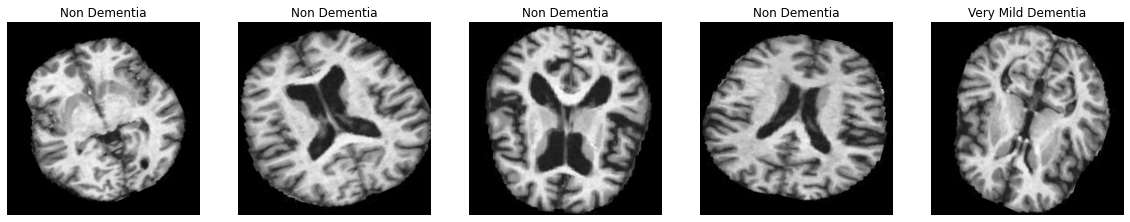

In [10]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Dementia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

In [11]:
# Model Initialization

base_model = DenseNet169(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")

In [12]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [13]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [14]:
# Summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 7, 7, 1664)        12642880  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1664)        0         
_________________________________________________________________
flatten (Flatten)            (None, 81536)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 81536)             326144    
_________________________________________________________________
dense (Dense)                (None, 2048)              166987776 
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
activation (Activation)      (None, 2048)              0

In [18]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [19]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 7,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath = './best_weights.hdf5', 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [20]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 25,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/25
33/33 [==============================] - 214s 6s/step - loss: 1.3308 - auc: 0.7806 - val_loss: 3.7952 - val_auc: 0.7488

Epoch 00001: val_auc improved from -inf to 0.74880, saving model to .\best_weights.hdf5
Epoch 2/25
33/33 [==============================] - 205s 6s/step - loss: 1.1025 - auc: 0.8311 - val_loss: 2.1412 - val_auc: 0.7560

Epoch 00002: val_auc improved from 0.74880 to 0.75597, saving model to .\best_weights.hdf5
Epoch 3/25
33/33 [==============================] - 205s 6s/step - loss: 1.0215 - auc: 0.8481 - val_loss: 1.5519 - val_auc: 0.7848

Epoch 00003: val_auc improved from 0.75597 to 0.78478, saving model to .\best_weights.hdf5
Epoch 4/25
33/33 [==============================] - 640s 20s/step - loss: 0.9521 - auc: 0.8608 - val_loss: 1.5246 - val_auc: 0.7512

Epoch 00004: val_auc did not improve from 0.78478
Epoch 5/25
33/33 [==============================] - 206s 6s/step - loss: 0.9193 - auc: 0.8620 - val_loss: 1.4288 - val_auc: 0.7636

Epoch 00005: val_au

In [21]:
model.save('./best_weights.hdf5')

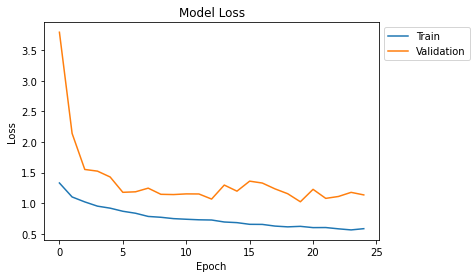

In [26]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()


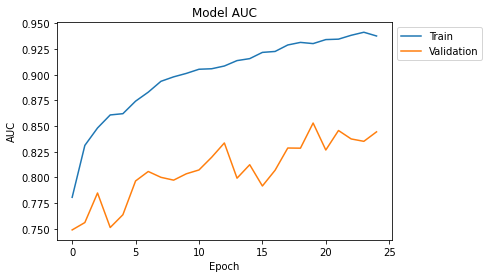

In [27]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [28]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = 'TEST',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 128)

Found 1279 images belonging to 4 classes.


In [29]:
# Evaluating Loss and AUC

model.evaluate(test_dataset)

10/10 [==============================] - 48s 5s/step - loss: 1.1297 - auc: 0.8777


[1.1296695470809937, 0.8777405619621277]

C:\Users\Rahul Raichur\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


100.0 % chances are there that the image is NonDemented


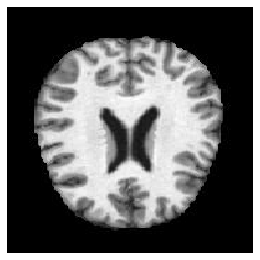

In [30]:
# Test Case 1: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('TEST/NonDemented/27 (4).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

83.32 % chances are there that the image is NonDemented


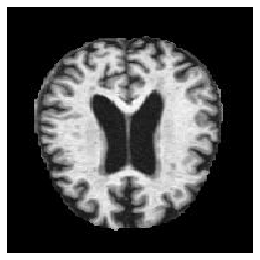

In [31]:
# Test Case 2: Mild demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('TEST/NonDemented/27 (3).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

67.9 % chances are there that the image is VeryMildDemented


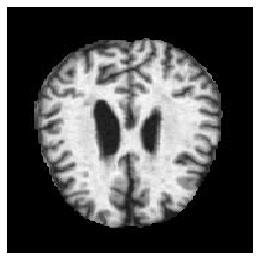

In [32]:
# Test Case 3: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('TEST/ModerateDemented/31.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

100.0 % chances are there that the image is NonDemented


C:\Users\Rahul Raichur\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


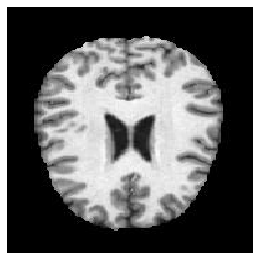

In [35]:
# Test Case 4: very mild demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('TEST/NonDemented/27 (19).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])


99.48 % chances are there that the image is ModerateDemented


C:\Users\Rahul Raichur\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


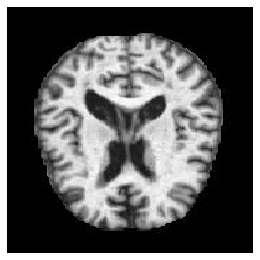

In [33]:
# MRI of a patient who was declared to be suffering from alzhiemer's disease by several other medical factors 

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('RealTime/AR.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

49.97 % chances are there that the image is VeryMildDemented


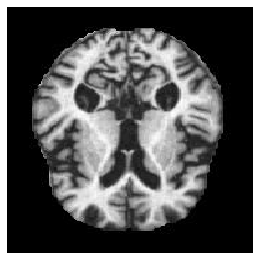

In [23]:
dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('RealTime/HA.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

99.97 % chances are there that the image is NonDemented


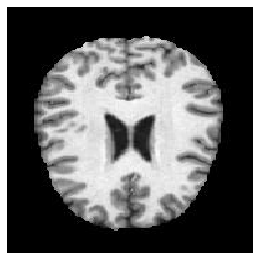

In [37]:
dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('TEST/NonDemented/27 (19).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

49.89 % chances are there that the image is ModerateDemented


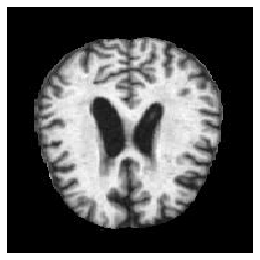

In [38]:
dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('TEST/ModerateDemented/28.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

42.57 % chances are there that the image is MildDemented


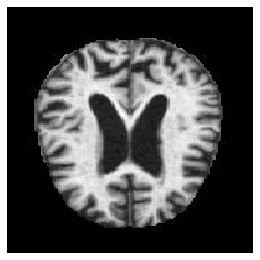

In [27]:
dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('RealTime/RT3.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

99.34 % chances are there that the image is NonDemented


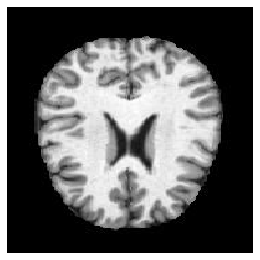

In [36]:
dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('RealTime/YR.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])